# Проверка гипотезы о нормальном распределении случайных величин

Импорт необходимых библиотек

In [1]:
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

pd.options.mode.copy_on_write = True
warnings.filterwarnings("ignore")

## Чтение и загрузка исходных и сохраненных ранее данных

### Чтение исходных данных
Загрузим наши исходные данные сразу в серию **ds**:

In [2]:
ds = pd.read_csv("data.txt", header=None)[0]
ds

0      62.205030
1      57.438075
2      59.852134
3      56.268755
4      58.469126
         ...    
123    58.991015
124    63.145081
125    58.386862
126    60.965588
127    59.430169
Name: 0, Length: 128, dtype: float64

### Загрузка сохраненных результатов расчета

Чтение файла ```"result_statistics.csv"```:

In [3]:
data = pd.read_csv("result_statistics.csv", delimiter=",", header=None)
data

,0,1
0,count,128.000000
1,M(X),60.123230
2,Mo(X),59.047368
3,Me(X),60.167023
4,D(X),9.023117
5,Std_dev(X),3.003850
6,Skewness,-0.225097
7,Kurtosis,-0.373055


Приведем полученный *DataFrame* к прежнему виду.

Для этого пересохраним его столбец 1 как объект *Series*:

In [4]:
result_statistics = pd.Series(data=data[1])
result_statistics

0    128.000000
1     60.123230
2     59.047368
3     60.167023
4      9.023117
5      3.003850
6     -0.225097
7     -0.373055
Name: 1, dtype: float64

И перепишем в нем индексы согласно столбцу 0 исходного *DataFrame*:

In [5]:
result_statistics.index = data[0]
result_statistics

0
count         128.000000
M(X)           60.123230
Mo(X)          59.047368
Me(X)          60.167023
D(X)            9.023117
Std_dev(X)      3.003850
Skewness       -0.225097
Kurtosis       -0.373055
Name: 1, dtype: float64

### Загрузка таблицы с основой вариационного ряда

In [6]:
table_2 = pd.read_csv("table_2.csv", delimiter=",", index_col=0)
table_2

,x_left,x_right,x_avr,n_f,p_f
0,51.790,53.747,52.7685,3,0.023438
1,53.747,55.704,54.7255,7,0.054688
2,55.704,57.661,56.6825,15,0.117188
3,57.661,59.619,58.6400,32,0.250000
4,59.619,61.576,60.5975,25,0.195312
5,61.576,63.533,62.5545,31,0.242188
6,63.533,65.490,64.5115,12,0.093750
7,65.490,67.448,66.4690,3,0.023438


## Приведение вариационного ряда к стандартному нормальному виду

Рассчитаем нормированные значения границ интервалов по формуле

$$ t_i = \frac{x_i - M(X)}{\sigma(X)}: $$

In [7]:
table_2["t_left"] = (table_2["x_left"] - result_statistics["M(X)"]) / result_statistics["Std_dev(X)"]
table_2["t_right"] = (table_2["x_right"] - result_statistics["M(X)"]) / result_statistics["Std_dev(X)"]
table_2

,x_left,x_right,x_avr,n_f,p_f,t_left,t_right
0,51.790,53.747,52.7685,3,0.023438,-2.774183,-2.122686
1,53.747,55.704,54.7255,7,0.054688,-2.122686,-1.471189
2,55.704,57.661,56.6825,15,0.117188,-1.471189,-0.819691
3,57.661,59.619,58.6400,32,0.250000,-0.819691,-0.167861
4,59.619,61.576,60.5975,25,0.195312,-0.167861,0.483636
5,61.576,63.533,62.5545,31,0.242188,0.483636,1.135133
6,63.533,65.490,64.5115,12,0.093750,1.135133,1.786630
7,65.490,67.448,66.4690,3,0.023438,1.786630,2.438460


Заменим внешние границы крайних интервалов на $ -\infty $ и $ +\infty $ :

In [8]:
table_2.loc[min(table_2.index), "t_left"] = -float("inf")
table_2.loc[max(table_2.index), "t_right"] = float("inf")
table_2

,x_left,x_right,x_avr,n_f,p_f,t_left,t_right
0,51.790,53.747,52.7685,3,0.023438,-inf,-2.122686
1,53.747,55.704,54.7255,7,0.054688,-2.122686,-1.471189
2,55.704,57.661,56.6825,15,0.117188,-1.471189,-0.819691
3,57.661,59.619,58.6400,32,0.250000,-0.819691,-0.167861
4,59.619,61.576,60.5975,25,0.195312,-0.167861,0.483636
5,61.576,63.533,62.5545,31,0.242188,0.483636,1.135133
6,63.533,65.490,64.5115,12,0.093750,1.135133,1.786630
7,65.490,67.448,66.4690,3,0.023438,1.786630,inf


### Создание объекта "нормального распределения"

Создадим из пакета ```stats``` библиотеки ```scipy``` объект стандартного нормального распределения с параметрами $M(X) = 0$ и $\sigma(X) = 1$.

Функция ```stats.norm(loc, scale)``` принимает две переменных:
* **loc** - Математическое ожидание;
* **scale** - Среднеквадратическое отклонение.

In [9]:
expected_value = 0
std_dev = 1

norm_distribution = stats.norm(loc=expected_value, scale=std_dev)
norm_distribution

Сохраненный в переменной ```norm_distribution``` объект позволяет:
* ```.rvs(size=1, random_state=None)``` генерировать выборки случайных величин из полученного закона;
* ```.pdf(x)``` получать значения функции плотности распределения $f(x)$;
* ```.cdf(x)``` получать значения функции распределения $F(x)$;
* ```.ppf(k)``` получать процентную точку распределения по вероятности (обратно методу ```.cdf(x)```).

Сгенерируем для примера массив из 10 случайных величин, подчиняющихся созданному нами нормальному закону распределения:

In [10]:
n = 10
norm_distribution.rvs(size=n)

array([ 0.292504  , -0.1855669 , -0.23231709, -0.52191113, -2.16810111,
       -0.67940628,  0.02043205,  0.22552905, -0.9646147 ,  0.34745631])

При перезапуске предыдущей ячейки мы каждый раз будем получать новые значения. Для того, чтобы этого избежать, необходимо указать значение дополнительной переменной **random_state**, фиксирующей начальную точку работы генератора случайных чисел:

In [11]:
n = 10
norm_distribution.rvs(size=n, random_state=42)

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004])

#### Построим графики функции распределения $F(x)$ и плотности распределения $f(x)$ для стандартного нормального закона:

Определим область построения графика по оси $x$ ограничив значения аргументов вероятностью попадания случайной величины в пределах от $ P_0 = (0.001 \dots 0.999) $ :

In [12]:
norm_distribution.ppf(0.001), norm_distribution.ppf(0.999)

(-3.090232306167813, 3.090232306167813)

Разобьем этот отрезок на один массив с шагом $0.1$:

In [13]:
step = 0.1
x = np.arange(norm_distribution.ppf(0.001), norm_distribution.ppf(0.999), step)
x

array([-3.09023231, -2.99023231, -2.89023231, -2.79023231, -2.69023231,
       -2.59023231, -2.49023231, -2.39023231, -2.29023231, -2.19023231,
       -2.09023231, -1.99023231, -1.89023231, -1.79023231, -1.69023231,
       -1.59023231, -1.49023231, -1.39023231, -1.29023231, -1.19023231,
       -1.09023231, -0.99023231, -0.89023231, -0.79023231, -0.69023231,
       -0.59023231, -0.49023231, -0.39023231, -0.29023231, -0.19023231,
       -0.09023231,  0.00976769,  0.10976769,  0.20976769,  0.30976769,
        0.40976769,  0.50976769,  0.60976769,  0.70976769,  0.80976769,
        0.90976769,  1.00976769,  1.10976769,  1.20976769,  1.30976769,
        1.40976769,  1.50976769,  1.60976769,  1.70976769,  1.80976769,
        1.90976769,  2.00976769,  2.10976769,  2.20976769,  2.30976769,
        2.40976769,  2.50976769,  2.60976769,  2.70976769,  2.80976769,
        2.90976769,  3.00976769])

Построим сам график функции плотности распределения функции $f(x)$ и  функции распределения $F(x)$ применив функционал библиотеки   ```matplotlib```:

* Создадим область построения графика:

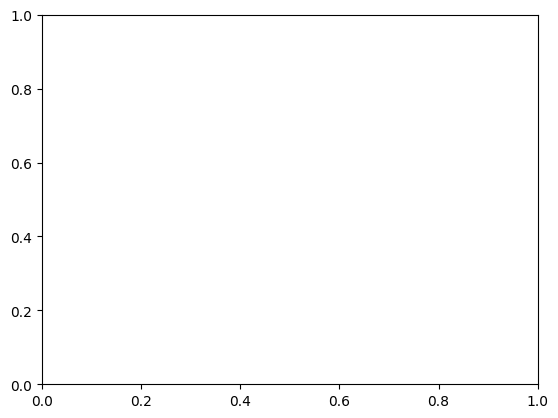

In [14]:
fig, ax = plt.subplots()
plt.show()

* Построим график функции плотности распределения функции $f(x)$:

> Функция ```.pdf(x)``` рассчитает значения функции плотности распределения $f(x)$ во всех точках массива $x$:

In [15]:
# Создадим массив аргументов для функции
x = np.arange(norm_distribution.ppf(0.001), norm_distribution.ppf(0.999), 0.1)
# Рассчитаем значения функции плотности распределения вероятностей  f(X)
norm_distribution.pdf(x)

array([0.00336709, 0.00456342, 0.00612326, 0.00813454, 0.01069891,
       0.01393168, 0.01796074, 0.02292462, 0.02896924, 0.03624342,
       0.04489297, 0.05505344, 0.06684173, 0.08034669, 0.09561925,
       0.11266258, 0.13142293, 0.15178178, 0.17355023, 0.19646617,
       0.220195  , 0.24433415, 0.26842189, 0.29195019, 0.31438125,
       0.33516725, 0.35377209, 0.36969418, 0.38248879, 0.39178867,
       0.39732151, 0.39892325, 0.39654609, 0.39026091, 0.38025373,
       0.36681659, 0.35033337, 0.33126161, 0.31011142, 0.28742297,
       0.26374378, 0.2396073 , 0.21551372, 0.19191409, 0.16919824,
       0.14768687, 0.12762771, 0.1091956 , 0.09249587, 0.0775705 ,
       0.06440623, 0.05294394, 0.04308853, 0.03471876, 0.02769643,
       0.02187461, 0.01710464, 0.01324173, 0.01014921, 0.00770153,
       0.00578601, 0.00430366])

* Подставим необходимые значения в функции построения графика:

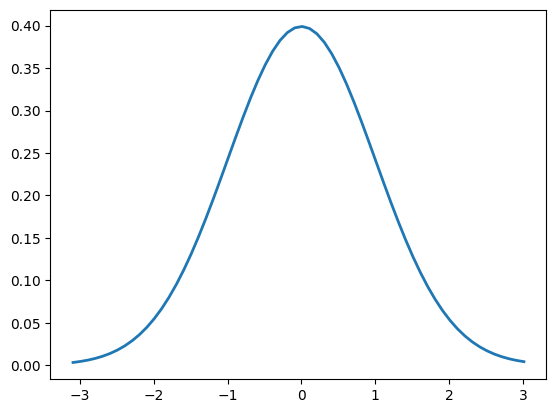

In [16]:
fig, ax = plt.subplots()
# Создание списка аргументов для функций
x = np.arange(norm_distribution.ppf(0.001), norm_distribution.ppf(0.999), 0.1)
# Построение графика функции плотности распределения функции f(x) на оси ax
ax.plot(x, norm_distribution.pdf(x), label="Функция плотности распределения $f(X)$", lw=2)
plt.show()

* Добавим к графику "легенду" и сетку:

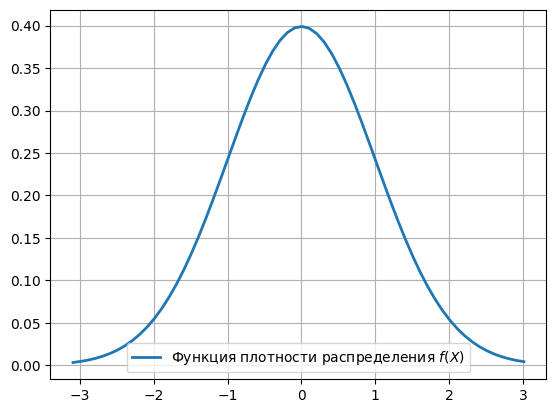

In [17]:
fig, ax = plt.subplots()
# Создание списка аргументов для функций
x = np.arange(norm_distribution.ppf(0.001), norm_distribution.ppf(0.999), 0.1)
# Построение графика функции плотности распределения функции f(x) на оси ax
ax.plot(x, norm_distribution.pdf(x), label="Функция плотности распределения $f(X)$", lw=2)
# Вывод сетки на график
ax.grid()
# Вывод легенды графика
ax.legend()
plt.show()

* Добавим график функции распределения функции $F(x)$:

> Функция ```.cdf(x)``` работает аналогично функции ```.pdf(x)``` только рассчитывает значения функции распределения $F(x)$:

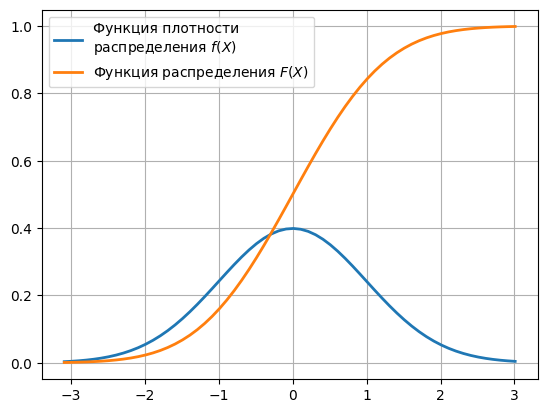

In [18]:
# Создание области построения графика
fig, ax = plt.subplots()

# Создание списка аргументов для функций
x = np.arange(norm_distribution.ppf(0.001), norm_distribution.ppf(0.999), 0.1)
# Построение графика функции плотности распределения функции f(x) на оси ax
ax.plot(x, norm_distribution.pdf(x), label="Функция плотности \nраспределения $f(X)$", lw=2)
# Построение графика функции распределения F(x) на оси ax
ax.plot(x, norm_distribution.cdf(x), label="Функция распределения $F(X)$", lw=2)
# Вывод сетки на график
ax.grid()
# Вывод легенды графика
ax.legend(loc="upper left")
# Показ графика
plt.show()

## Проверка гипотезы о нормальности распределения по критерию $\chi^2$ Пирсона

### Найдем теоретические частости $p_т$ и частоты $n_т$ попадания в интервалы

Рассчитаем значения $\frac{1}{2}Ф(t_i)$ эквивалентные полученным ранее значением из таблицы интеграла вероятности

In [19]:
table_2["1/2Ф(t_л)"] = 0.5 * (norm_distribution.cdf(table_2["t_left"]) - norm_distribution.cdf(-table_2["t_left"]))
table_2["1/2Ф(t_пр)"] = 0.5 * (norm_distribution.cdf(table_2["t_right"]) - norm_distribution.cdf(-table_2["t_right"]))
table_2

,x_left,x_right,x_avr,n_f,p_f,t_left,t_right,1/2Ф(t_л),1/2Ф(t_пр)
0,51.790,53.747,52.7685,3,0.023438,-inf,-2.122686,-0.500000,-0.483110
1,53.747,55.704,54.7255,7,0.054688,-2.122686,-1.471189,-0.483110,-0.429380
2,55.704,57.661,56.6825,15,0.117188,-1.471189,-0.819691,-0.429380,-0.293804
3,57.661,59.619,58.6400,32,0.250000,-0.819691,-0.167861,-0.293804,-0.066654
4,59.619,61.576,60.5975,25,0.195312,-0.167861,0.483636,-0.066654,0.185678
5,61.576,63.533,62.5545,31,0.242188,0.483636,1.135133,0.185678,0.371840
6,63.533,65.490,64.5115,12,0.093750,1.135133,1.786630,0.371840,0.463001
7,65.490,67.448,66.4690,3,0.023438,1.786630,inf,0.463001,0.500000


Найдем теоретические частости 
$$ p_т = \frac12 Ф(t_{пр}) - \frac12 Ф(t_{л})   :$$

In [20]:
table_2["p_t"] = table_2["1/2Ф(t_пр)"] - table_2["1/2Ф(t_л)"]
table_2

,x_left,x_right,x_avr,n_f,p_f,t_left,t_right,1/2Ф(t_л),1/2Ф(t_пр),p_t
0,51.790,53.747,52.7685,3,0.023438,-inf,-2.122686,-0.500000,-0.483110,0.016890
1,53.747,55.704,54.7255,7,0.054688,-2.122686,-1.471189,-0.483110,-0.429380,0.053730
2,55.704,57.661,56.6825,15,0.117188,-1.471189,-0.819691,-0.429380,-0.293804,0.135576
3,57.661,59.619,58.6400,32,0.250000,-0.819691,-0.167861,-0.293804,-0.066654,0.227150
4,59.619,61.576,60.5975,25,0.195312,-0.167861,0.483636,-0.066654,0.185678,0.252332
5,61.576,63.533,62.5545,31,0.242188,0.483636,1.135133,0.185678,0.371840,0.186162
6,63.533,65.490,64.5115,12,0.093750,1.135133,1.786630,0.371840,0.463001,0.091161
7,65.490,67.448,66.4690,3,0.023438,1.786630,inf,0.463001,0.500000,0.036999


Проверим, что сумма полученных частостей $p_т$ равна единице:

In [21]:
table_2.sum()["p_t"]

1.0

Рассчитаем теоретические частоты 

$$ n_т = p_т \cdot N : $$

In [22]:
table_2["n_t"] = table_2["p_t"] * result_statistics["count"]
table_2

,x_left,x_right,x_avr,n_f,p_f,t_left,t_right,1/2Ф(t_л),1/2Ф(t_пр),p_t,n_t
0,51.790,53.747,52.7685,3,0.023438,-inf,-2.122686,-0.500000,-0.483110,0.016890,2.161932
1,53.747,55.704,54.7255,7,0.054688,-2.122686,-1.471189,-0.483110,-0.429380,0.053730,6.877435
2,55.704,57.661,56.6825,15,0.117188,-1.471189,-0.819691,-0.429380,-0.293804,0.135576,17.353722
3,57.661,59.619,58.6400,32,0.250000,-0.819691,-0.167861,-0.293804,-0.066654,0.227150,29.075220
4,59.619,61.576,60.5975,25,0.195312,-0.167861,0.483636,-0.066654,0.185678,0.252332,32.298451
5,61.576,63.533,62.5545,31,0.242188,0.483636,1.135133,0.185678,0.371840,0.186162,23.828785
6,63.533,65.490,64.5115,12,0.093750,1.135133,1.786630,0.371840,0.463001,0.091161,11.668629
7,65.490,67.448,66.4690,3,0.023438,1.786630,inf,0.463001,0.500000,0.036999,4.735826


Проверим, что $\sum n_т = N $:

In [23]:
table_2.sum()["n_t"]

128.0

Вычислим $\chi^2$-расстояние для каждого интервала


$$ \frac{(n_{ф_i} - n_{т_i})^2}{n_{т_i}} :$$

In [24]:
table_2["(n_f-n_t)^2 / n_t"] = ((table_2["n_f"] - table_2["n_t"]) ** 2 ) / table_2["n_t"]
table_2

,x_left,x_right,x_avr,n_f,p_f,t_left,t_right,1/2Ф(t_л),1/2Ф(t_пр),p_t,n_t,(n_f-n_t)^2 / n_t
0,51.790,53.747,52.7685,3,0.023438,-inf,-2.122686,-0.500000,-0.483110,0.016890,2.161932,0.324875
1,53.747,55.704,54.7255,7,0.054688,-2.122686,-1.471189,-0.483110,-0.429380,0.053730,6.877435,0.002184
2,55.704,57.661,56.6825,15,0.117188,-1.471189,-0.819691,-0.429380,-0.293804,0.135576,17.353722,0.319240
3,57.661,59.619,58.6400,32,0.250000,-0.819691,-0.167861,-0.293804,-0.066654,0.227150,29.075220,0.294214
4,59.619,61.576,60.5975,25,0.195312,-0.167861,0.483636,-0.066654,0.185678,0.252332,32.298451,1.649224
5,61.576,63.533,62.5545,31,0.242188,0.483636,1.135133,0.185678,0.371840,0.186162,23.828785,2.158160
6,63.533,65.490,64.5115,12,0.093750,1.135133,1.786630,0.371840,0.463001,0.091161,11.668629,0.009410
7,65.490,67.448,66.4690,3,0.023438,1.786630,inf,0.463001,0.500000,0.036999,4.735826,0.636234


Тогда фактическое значение $\chi^2_f$ будет равно:

$$ \chi^2_f = \sum_{i=1}^{n} \frac{(n_{ф_i} - n_{т_i})^2}{n_{т_i}} $$

In [25]:
chi_square_fact = table_2.sum()["(n_f-n_t)^2 / n_t"]
chi_square_fact

5.393542387781168

### Создание объекта "$\chi^2$ распределения Пирсона"

Функция ```stats.chi2(df)``` принимает одну переменную:
* **df** - Количество степеней свобод.

Для примера построим на одном графике несколько $\chi^2$ распределений при степенях свобод от **start_df** до **end_df**:

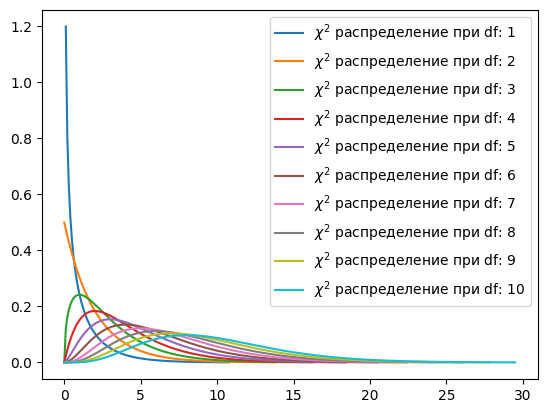

In [26]:
start_df = 1
end_df = 10

fig, ax = plt.subplots()

for df in range(start_df, end_df + 1):
    chi2_distribution = stats.chi2(df=df)
    x = np.arange(chi2_distribution.ppf(0), chi2_distribution.ppf(0.999), 0.1)
    ax.plot(x, chi2_distribution.pdf(x), label=f"$\chi^2$ распределение при df: {df}")

plt.legend()
plt.show()

В контексте нашей задачи дельта степеней свобод (delta degrees of freedom) равна 2, тогда в общем случае у нашего распределения останется:
$$ r = n - 1 - ddof $$
степеней свобод.

In [27]:
ddof = 2

degrees_of_freedom = len(table_2) - 1 - ddof
degrees_of_freedom

5

Создадим сам объект $\chi^2$ распределения Пирсона:

In [28]:
chi2_distribution = stats.chi2(df=degrees_of_freedom)

Используем метод ```.ppf(p_0)``` для нахождения критического значения $\chi^2$ для доверительной вероятности $p_0$:

In [29]:
p_0 = 0.95

chi2_critical = chi2_distribution.ppf(p_0)
chi2_critical

11.070497693516351

Проверим нашу гипотезу по критерию Пирсона:

$$ \chi_{fact}^2 \le \chi_{p_0}^2 $$

In [30]:
"Гипотеза не отвергается" if chi_square_fact <= chi2_critical else "Гипотеза отвергается"

'Гипотеза не отвергается'

### Построим график $\chi^2$ распределения

* Построим функцию плотности ранее полученного $\chi^2$ распределения **chi2_distribution**:

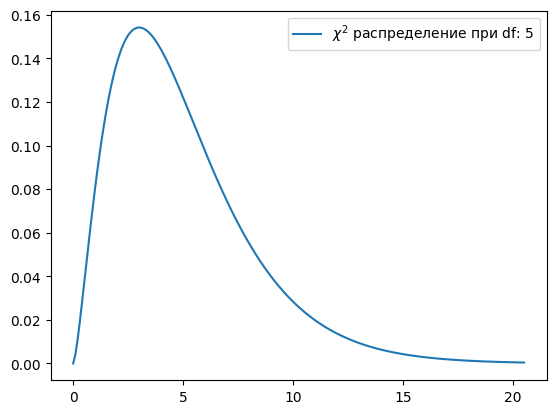

In [31]:
fig, ax = plt.subplots()
x = np.arange(chi2_distribution.ppf(0), chi2_distribution.ppf(0.999), 0.1)
ax.plot(x, chi2_distribution.pdf(x), label=f"$\chi^2$ распределение при df: {degrees_of_freedom}")
plt.legend()
plt.show()

* Отметим на графике область принятия и отрицания гипотезы:

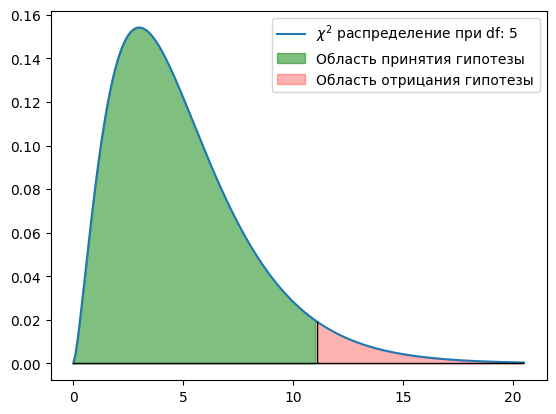

In [32]:
fig, ax = plt.subplots()
x = np.arange(chi2_distribution.ppf(0), chi2_distribution.ppf(0.999), 0.1)

ax.plot(x, chi2_distribution.pdf(x), label=f"$\chi^2$ распределение при df: {degrees_of_freedom}")

# Выбор аргументов из x попадающих в промежуток x < chi2_critical
x_gr = x[x < chi2_critical]
# Заливка области принятия гипотезы
ax.fill_between(x_gr, 
                chi2_distribution.pdf(x[x < chi2_critical]), 
                color="g", alpha=0.5, label="Область принятия гипотезы")

# Выбор аргументов из x попадающих в промежуток chi2_critical < x < x_max
x_red = x[(x>chi2_critical) & (x< max(x))]
# Заливка области отрицания гипотезы
ax.fill_between(x_red, 
                chi2_distribution.pdf(x_red), 
                alpha=0.3, color="r", label="Область отрицания гипотезы")

# Построение линий разделяющих области 
ax.hlines(0, 0, max(x), lw=1, color="black") # Горизонтальная линия от точки (0, 0) длиной max(x)
# Вертикальная линия от точки (chi2_critical, 0) высотой f(chi2_critical)
ax.vlines(chi2_critical, 0, chi2_distribution.pdf(chi2_critical), color="black", lw=1)

plt.legend()
plt.show()

* Добавим на график наше фактическое значение $\chi^2$:

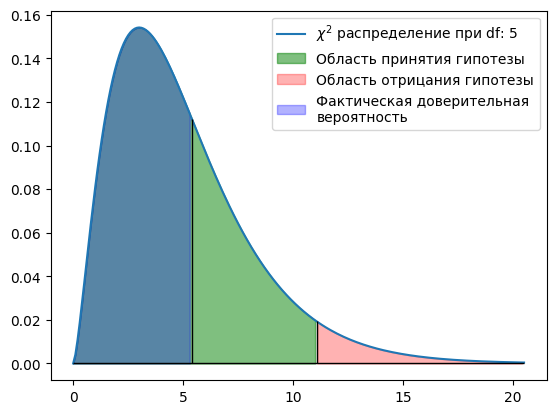

In [33]:
fig, ax = plt.subplots()
x = np.arange(chi2_distribution.ppf(0), chi2_distribution.ppf(0.999), 0.1)

ax.plot(x, chi2_distribution.pdf(x), label=f"$\chi^2$ распределение при df: {degrees_of_freedom}")

# Выбор аргументов из x попадающих в промежуток x < chi2_critical
x_gr = x[x < chi2_critical]
# Заливка области принятия гипотезы
ax.fill_between(x_gr, 
                chi2_distribution.pdf(x[x < chi2_critical]), 
                color="g", alpha=0.5, label="Область принятия гипотезы")

# Выбор аргументов из x попадающих в промежуток chi2_critical < x < x_max
x_red = x[(x>chi2_critical) & (x< max(x))] # & (x<z)
# Заливка области отрицания гипотезы
ax.fill_between(x_red, 
                chi2_distribution.pdf(x_red), 
                alpha=0.3, color="r", label="Область отрицания гипотезы")

# Построение линий, разделяющих области 
ax.hlines(0, 0, max(x), lw=1, color="black") # Горизонтильная линия от точки (0, 0) длиной max(x)
# Вертикальная линия от точки (chi2_critical, 0) высотой f(chi2_critical)
ax.vlines(chi2_critical, 0, chi2_distribution.pdf(chi2_critical), color="black", lw=1)

# Заливка области фактической доверительной вероятности
ax.fill_between(x[x < chi_square_fact], 
                chi2_distribution.pdf(x[x < chi_square_fact]), 
                color="b", alpha=0.3, label="Фактическая доверительная \nвероятность")

# Построение вертикальной границы в точке chi_square_fact
ax.vlines(chi_square_fact, 0, chi2_distribution.pdf(chi_square_fact), color="black", lw=1)

plt.legend()
# Сохраним полeченный график в файл "f(x)_graf.png"
plt.savefig("Pirson_test.png")

plt.show()

### Проверка гипотезы по критерию Пирсона стандартными средствами

Используем функцию ```stats.chisquare(f_obs, f_exp, ddof)``` из библиотеки ```scipy```

Переменные:
* **f_obs** - список фактических частот $n_f$, попавших в интервалы;
* **f_exp** - список ожидаемых теоретических частот $n_t$;
* **ddof** - дельта степеней свобод (в нашем случае 2 (переменная **ddof** была определена ранее)).

In [34]:
ddof = 2
chi_test_scipy = stats.chisquare(f_obs=table_2["n_f"], f_exp=table_2["n_t"], ddof=ddof)
chi_test_scipy

Power_divergenceResult(statistic=5.393542387781168, pvalue=0.3697605854969096)

В результате создания объекта мы видим рассчитанное значение **chi_square_fact** и значение pvalue равное:

$$ pvalue = 1 - P_{0_{fact}} $$

Cравним эти значения с теми, что мы получили ранее:

In [35]:
p_val = 1 - chi2_distribution.cdf(chi_square_fact)
chi_square_fact, p_val

(5.393542387781168, 0.3697605854969096)

Получить сами значения из объекта $\chi^2$ теста можно обратившись к атрибутам объекта напрямую:

In [36]:
chi_square_fact_scipy = chi_test_scipy.statistic
p_val_scipy = chi_test_scipy.pvalue

chi_square_fact_scipy, p_val_scipy

(5.393542387781168, 0.3697605854969096)

### Альтернативный расчет значений теоретической частоты $n_т$

Создадим новую подтаблицу **table_3** из таблицы **table_2**

In [37]:
table_3 = table_2[["x_left", "x_right", "n_f"]]
table_3

,x_left,x_right,n_f
0,51.790,53.747,3
1,53.747,55.704,7
2,55.704,57.661,15
3,57.661,59.619,32
4,59.619,61.576,25
5,61.576,63.533,31
6,63.533,65.490,12
7,65.490,67.448,3


Заменим крайние значения интервалов на $\pm \infty$:

In [38]:
table_3.loc[min(table_3.index), "x_left"] = -float("inf")
table_3.loc[max(table_3.index), "x_right"] = float("inf")
table_3

,x_left,x_right,n_f
0,-inf,53.747,3
1,53.747,55.704,7
2,55.704,57.661,15
3,57.661,59.619,32
4,59.619,61.576,25
5,61.576,63.533,31
6,63.533,65.490,12
7,65.490,inf,3


Создадим объект нормального распределения с нашими параметрами $M(x)$ и $\sigma(x)$:

In [39]:
custom_norm_distr = stats.norm(loc=result_statistics["M(X)"], scale=result_statistics["Std_dev(X)"])

Рассчитаем значения теоретических вероятностей $p_t$ как разность значений функции распределения

$$ p_{t_i} = F(x_{пр_i}) - F(x_{л_i})$$


In [40]:
table_3["p_t"] = custom_norm_distr.cdf(table_3["x_right"]) - custom_norm_distr.cdf(table_3["x_left"])
table_3

,x_left,x_right,n_f,p_t
0,-inf,53.747,3,0.016890
1,53.747,55.704,7,0.053730
2,55.704,57.661,15,0.135576
3,57.661,59.619,32,0.227150
4,59.619,61.576,25,0.252332
5,61.576,63.533,31,0.186162
6,63.533,65.490,12,0.091161
7,65.490,inf,3,0.036999


Проверим, что $ \sum p_t = 1 $:

In [41]:
table_3.sum()["p_t"]

1.0

Рассчитаем теоретические частоты $ n_t $ как $ p_t \cdot N $:

In [42]:
table_3["n_t"] = table_3["p_t"] * result_statistics["count"]
table_3

,x_left,x_right,n_f,p_t,n_t
0,-inf,53.747,3,0.016890,2.161932
1,53.747,55.704,7,0.053730,6.877435
2,55.704,57.661,15,0.135576,17.353722
3,57.661,59.619,32,0.227150,29.075220
4,59.619,61.576,25,0.252332,32.298451
5,61.576,63.533,31,0.186162,23.828785
6,63.533,65.490,12,0.091161,11.668629
7,65.490,inf,3,0.036999,4.735826


Проверим, что $ \sum n_t = N $:

In [43]:
table_3.sum()["n_t"]

128.0

Сравним полученные значения с **table_2**: 

In [44]:
table_2[["x_left", "x_right", "n_f", "p_t", "n_t"]]

,x_left,x_right,n_f,p_t,n_t
0,51.790,53.747,3,0.016890,2.161932
1,53.747,55.704,7,0.053730,6.877435
2,55.704,57.661,15,0.135576,17.353722
3,57.661,59.619,32,0.227150,29.075220
4,59.619,61.576,25,0.252332,32.298451
5,61.576,63.533,31,0.186162,23.828785
6,63.533,65.490,12,0.091161,11.668629
7,65.490,67.448,3,0.036999,4.735826


## Критерий Колмогорова-Смирнова

Для проверки гипотезы о нормальности распределения по критерию Колмогорова-Смирнова рассчитаем накопленные фактические $p_ф$ и теоретические $p_т$ частоты: 

In [45]:
table_2["p_f_cum"] = table_2["p_f"].cumsum()
table_2["p_t_cum"] = table_2["p_t"].cumsum()
table_2[["x_left", "x_right", "x_avr", "n_f", "p_f", "p_t", "n_t", "p_f_cum", "p_t_cum"]]

,x_left,x_right,x_avr,n_f,p_f,p_t,n_t,p_f_cum,p_t_cum
0,51.790,53.747,52.7685,3,0.023438,0.016890,2.161932,0.023438,0.016890
1,53.747,55.704,54.7255,7,0.054688,0.053730,6.877435,0.078125,0.070620
2,55.704,57.661,56.6825,15,0.117188,0.135576,17.353722,0.195312,0.206196
3,57.661,59.619,58.6400,32,0.250000,0.227150,29.075220,0.445312,0.433346
4,59.619,61.576,60.5975,25,0.195312,0.252332,32.298451,0.640625,0.685678
5,61.576,63.533,62.5545,31,0.242188,0.186162,23.828785,0.882812,0.871840
6,63.533,65.490,64.5115,12,0.093750,0.091161,11.668629,0.976562,0.963001
7,65.490,67.448,66.4690,3,0.023438,0.036999,4.735826,1.000000,1.000000


Найдем абсолютную разность $D$ между фактической $p_ф$ и теоретической $p_т$ частотью:

$$ D = |\sum p_ф - \sum p_т | $$

In [46]:
table_2["D"] = abs(table_2["p_f_cum"] - table_2["p_t_cum"])
table_2[["x_left", "x_right", "x_avr", "n_f", "p_f", "p_t", "n_t", "p_f_cum", "p_t_cum", "D"]]

,x_left,x_right,x_avr,n_f,p_f,p_t,n_t,p_f_cum,p_t_cum,D
0,51.790,53.747,52.7685,3,0.023438,0.016890,2.161932,0.023438,0.016890,0.006547
1,53.747,55.704,54.7255,7,0.054688,0.053730,6.877435,0.078125,0.070620,0.007505
2,55.704,57.661,56.6825,15,0.117188,0.135576,17.353722,0.195312,0.206196,0.010884
3,57.661,59.619,58.6400,32,0.250000,0.227150,29.075220,0.445312,0.433346,0.011966
4,59.619,61.576,60.5975,25,0.195312,0.252332,32.298451,0.640625,0.685678,0.045053
5,61.576,63.533,62.5545,31,0.242188,0.186162,23.828785,0.882812,0.871840,0.010972
6,63.533,65.490,64.5115,12,0.093750,0.091161,11.668629,0.976562,0.963001,0.013561
7,65.490,67.448,66.4690,3,0.023438,0.036999,4.735826,1.000000,1.000000,0.000000


Найдем максимальную разность $D$:

In [47]:
d_max = max(table_2["D"])
d_max

0.04505281546172535

Фактическое значение статистики $\lambda$ может быть найдено по формуле:

$$\lambda_{f} = D_{\max} \cdot \sqrt{N} $$

In [48]:
lambda_fact = d_max * result_statistics["count"] ** 0.5
lambda_fact

0.5097144211925141

Критеческое значение $\lambda$ для доверительной вероятности $P_0$ при $P_0 \approx 1$ может быть найдено по формуле:

$$ \lambda_{P_0} \approx \sqrt{-\frac{1}{2}\ln \frac{1-P_0}{2}} $$

In [49]:
p_0 = 0.95

lambda_critical = (-0.5 * math.log((1 - p_0) / 2, math.e)) ** 0.5
lambda_critical

1.3581015157406193

Проверим нашу гипотезу по критерию Колмогорова-Смирнова:

$$ \lambda_{fact} \le \lambda_{p_0} $$

In [50]:
"Гипотеза не отвергается" if lambda_fact <= lambda_critical else "Гипотеза отвергается"

'Гипотеза не отвергается'

### Проверка гипотезы по критерию Колмогорова-Смирнова стандартными средствами

Используем функцию ```stats.kstest(rvs, cdf, args)``` из библиотеки ```scipy```

Переменные:
* **rvs** - выборка значений, для которой выполняется проверка;
* **cdf** - функция плотности распределения $F(x)$ проверяемого закона распределения;
* **args** - необходимые параметры для расчета функции плотности распределения $F(x)$ (могут быть определены при создании объекта закона распределения).

Выполним проверку по критерию Колмогорова-Смирнова для исходного набора данных из нашей серии **ds** с параметрами нормального распределения расчитанными из вариационного ряда:

In [51]:
stats.kstest(rvs=ds, cdf=stats.norm.cdf, args=(result_statistics["M(X)"], result_statistics["Std_dev(X)"]))

KstestResult(statistic=0.06097804188320988, pvalue=0.7045976411793098, statistic_location=61.9900174, statistic_sign=-1)

Аналогичный результат может быть получен с помощью явной передачи параметров нормального закона при создании объекта распределения:

In [52]:
stats.kstest(rvs=ds, cdf=stats.norm(loc=result_statistics["M(X)"], scale=result_statistics["Std_dev(X)"]).cdf)

KstestResult(statistic=0.06097804188320988, pvalue=0.7045976411793098, statistic_location=61.9900174, statistic_sign=-1)

***

Мы можем напрямую рассчитать необходимые нам параметры нормального закона, применив к исходной серии **ds** методы ```.mean()``` и ```std()```:

In [53]:
stats.kstest(ds, stats.norm(loc=ds.mean(), scale=ds.std()).cdf)

KstestResult(statistic=0.05767973852919028, pvalue=0.7658616608701084, statistic_location=61.9900174, statistic_sign=-1)

отметим, что в последнем случае мы получили меньшее значение статистики $D$ (атрибут statistic полученного объекта KstestResult), что объясняется более точными значениями $M(x)$ и $\sigma(x)$, получаемыми из исходной серии данных **ds** напрямую.

## Построим графики функции плотности распределения $f(x)$ и функции распределения $F(x)$ 

### График функции плотности распределения $f(x)$

Создадим список с границами интервалов из вариационного ряда: 

In [54]:
bins = list(table_2["x_left"])
bins.append(table_2["x_right"][max(table_2.index)])
bins

[51.79, 53.747, 55.704, 57.661, 59.619, 61.576, 63.533, 65.49, 67.448]

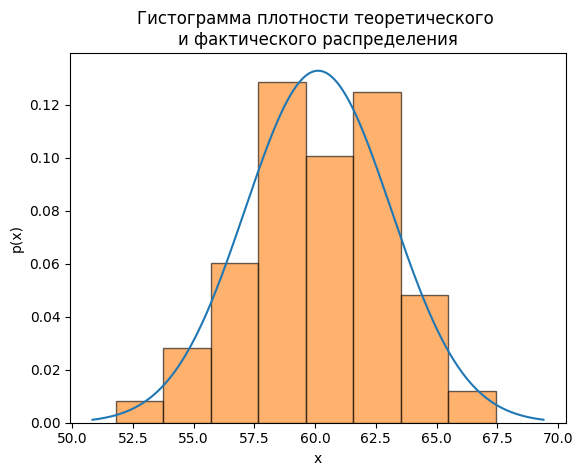

In [55]:
# Загрузим библиотеку matplotlib для построения графиков
import matplotlib.pyplot as plt

# Создадим объект нормального распределения с параметрами, полученными из вариационного ряда 
norm_func = stats.norm(loc=result_statistics["M(X)"], scale=result_statistics["Std_dev(X)"])

# Создадим список аргументов для функции 
x = np.arange(norm_func.ppf(0.001), norm_func.ppf(0.999), 0.01)

# Создадим область построения графика
fig, ax = plt.subplots()

# Добавим на нее линейный график теоретической функции плотности распредления 
ax.plot(x, norm_func.pdf(x), label="Теоретическая функция \nплотности нормального распределения")

# Добавим на нее фактическую гистограмму плотности распредления 
# Построенную по исходной серии данных ds с определенными выше границами интервалов bins
ax.hist(ds, edgecolor = 'black', density=True, alpha=0.6,
         bins = bins, label="Гистограмма фактической плотности распределения")

# Добавим подписи осей и название графика
plt.title("Гистограмма плотности теоретического \nи фактического распределения")
plt.xlabel("x")
plt.ylabel("p(x)")
# plt.grid()
# plt.legend(loc="upper right")

# Сохраним полученный график в файл "f(x)_graf.png"
plt.savefig("f(x)_graf_1.png")

plt.show()

### График теоретической и фактической функции распределения F(x)

При построении графика функции распределения $F(x)$ будем использовать ранее определенную переменную **bins**, содержащую границы наших интервалов:

In [56]:
bins

[51.79, 53.747, 55.704, 57.661, 59.619, 61.576, 63.533, 65.49, 67.448]

Создадим переменную **p_f_cum**, содержащую список накопленных частостей $\sum p_t$ в точках, попадающих на наши границы интервалов:

In [57]:
# Возьмем данные из нашей таблицы table_2
p_f_cum = list(table_2["p_f_cum"])
# Добавим в полученный список накопленную вероятность, равную 0 на 0 позицию списка
p_f_cum.insert(0, 0)
p_f_cum

[0,
 0.0234375,
 0.078125,
 0.1953125,
 0.4453125,
 0.640625,
 0.8828125,
 0.9765625,
 1.0]

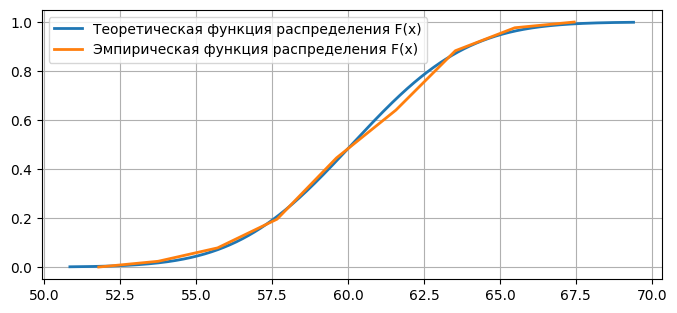

In [58]:
# Загрузим библиотеку matplotlib для построения графиков
import matplotlib.pyplot as plt

# Создадим объект нормального распределения с параметрами, полученными из вариационного ряда 
norm_func = stats.norm(loc=result_statistics["M(X)"], scale=result_statistics["Std_dev(X)"])

# Создадим область построения графика
plt.figure(figsize=(8, 3.5))

# Создадим список аргументов для функции 
x = np.arange(norm_func.ppf(0.001), norm_func.ppf(0.999), 0.01)

# Построим на оси ax линейный график теоретической функции распредления F(x)
plt.plot(x, norm_func.cdf(x), 
         label="Теоретическая функция распределения F(x)", lw=2)

# Построим на оси ax линейный график эмпирической функции распредления F(x)
plt.plot(bins, p_f_cum, label="Эмпирическая функция распределения F(x)", lw=2)

plt.legend()
plt.grid()
plt.show()

#### Построим наш график точнее, используя все исходные данные из серии **ds**

Для этого:

*  Отсортируем нашу серию **ds** по возрастанию и сохраним результат в серию **ds_sort**:

In [59]:
ds_sort = ds.sort_values()
ds_sort

43     51.789754
35     53.371319
103    53.632930
24     53.954021
78     54.167908
         ...    
9      65.211240
63     65.218526
120    66.449405
105    66.594009
111    66.944692
Name: 0, Length: 128, dtype: float64

* Раcсчитаем накопленные частости $ \sum p_т $ к каждому значению отсортированной серии **ds_sort**:

In [60]:
p_f_cum = [(idx) / result_statistics["count"] for idx in range(int(result_statistics["count"]))]
p_f_cum

[0.0,
 0.0078125,
 0.015625,
 0.0234375,
 0.03125,
 0.0390625,
 0.046875,
 0.0546875,
 0.0625,
 0.0703125,
 0.078125,
 0.0859375,
 0.09375,
 0.1015625,
 0.109375,
 0.1171875,
 0.125,
 0.1328125,
 0.140625,
 0.1484375,
 0.15625,
 0.1640625,
 0.171875,
 0.1796875,
 0.1875,
 0.1953125,
 0.203125,
 0.2109375,
 0.21875,
 0.2265625,
 0.234375,
 0.2421875,
 0.25,
 0.2578125,
 0.265625,
 0.2734375,
 0.28125,
 0.2890625,
 0.296875,
 0.3046875,
 0.3125,
 0.3203125,
 0.328125,
 0.3359375,
 0.34375,
 0.3515625,
 0.359375,
 0.3671875,
 0.375,
 0.3828125,
 0.390625,
 0.3984375,
 0.40625,
 0.4140625,
 0.421875,
 0.4296875,
 0.4375,
 0.4453125,
 0.453125,
 0.4609375,
 0.46875,
 0.4765625,
 0.484375,
 0.4921875,
 0.5,
 0.5078125,
 0.515625,
 0.5234375,
 0.53125,
 0.5390625,
 0.546875,
 0.5546875,
 0.5625,
 0.5703125,
 0.578125,
 0.5859375,
 0.59375,
 0.6015625,
 0.609375,
 0.6171875,
 0.625,
 0.6328125,
 0.640625,
 0.6484375,
 0.65625,
 0.6640625,
 0.671875,
 0.6796875,
 0.6875,
 0.6953125,
 0.703125,


* Объединим полученные данные в общий *DataFrame* **plot_data**:

In [61]:
plot_data = pd.DataFrame({"x": ds_sort, "p_f_cum": p_f_cum})
plot_data

,x,p_f_cum
43,51.789754,0.000000
35,53.371319,0.007812
103,53.632930,0.015625
24,53.954021,0.023438
78,54.167908,0.031250
...,...,...
9,65.211240,0.960938
63,65.218526,0.968750
120,66.449405,0.976562
105,66.594009,0.984375


* Построим график по полученным данным:

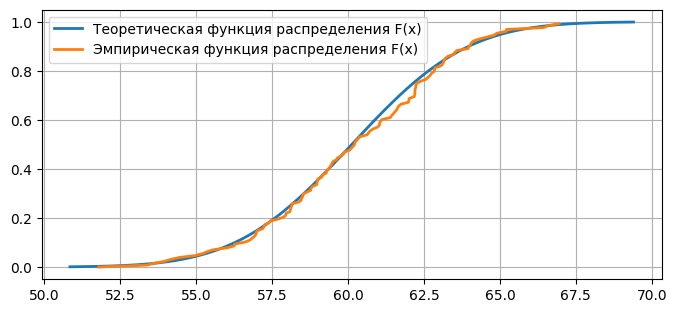

In [62]:
import matplotlib.pyplot as plt

# Создадим объект нормального распределения с параметрами, полученными из вариационного ряда 
norm_func = stats.norm(loc=result_statistics["M(X)"], scale=result_statistics["Std_dev(X)"])

# Создадим список аргументов для функции 
x = np.arange(norm_func.ppf(0.001), norm_func.ppf(0.999), 0.01)

# Создадим область построения графика
plt.figure(figsize=(8, 3.5))

# Построим на оси ax линейный график теоретической функции распредления F(x)
plt.plot(x, norm_func.cdf(x), label="Теоретическая функция распределения F(x)", lw=2)

# Построим на оси ax линейный график эмпирической функции распредления F(x)
plt.plot(plot_data["x"], plot_data["p_f_cum"], label="Эмпирическая функция распределения F(x)", lw=2)

plt.legend()
plt.grid()

# Сохраним полученный график в файл "F(x)_graf.png"
plt.savefig("F(x)_graf_2.png")

plt.show()

Рассчитаем значение **D** статистики по этим данным.

Для этого:

* Добавим в наш *DataFrame* столбец **p_t_cum**, заполнив его значениями теоретической функции распределения $F(x)$:

In [63]:
plot_data["p_t_cum"] = stats.norm(loc=result_statistics["M(X)"], scale=result_statistics["Std_dev(X)"]).cdf(plot_data["x"])
plot_data                                                                   

,x,p_f_cum,p_t_cum
43,51.789754,0.000000,0.002766
35,53.371319,0.007812,0.012296
103,53.632930,0.015625,0.015361
24,53.954021,0.023438,0.019999
78,54.167908,0.031250,0.023708
...,...,...,...
9,65.211240,0.960938,0.954851
63,65.218526,0.968750,0.955081
120,66.449405,0.976562,0.982399
105,66.594009,0.984375,0.984386


Рассчитаем **D** статистику как:

$$ D = |\sum p_ф - \sum p_т | $$

In [64]:
plot_data["D"] = abs(plot_data["p_t_cum"] - plot_data["p_f_cum"])
plot_data

,x,p_f_cum,p_t_cum,D
43,51.789754,0.000000,0.002766,0.002766
35,53.371319,0.007812,0.012296,0.004483
103,53.632930,0.015625,0.015361,0.000264
24,53.954021,0.023438,0.019999,0.003438
78,54.167908,0.031250,0.023708,0.007542
...,...,...,...,...
9,65.211240,0.960938,0.954851,0.006086
63,65.218526,0.968750,0.955081,0.013669
120,66.449405,0.976562,0.982399,0.005836
105,66.594009,0.984375,0.984386,0.000011


Найдем максимальное значение статистики $D_{\max}$:

In [65]:
d_max = plot_data.max()["D"]
d_max

0.06097804188320988

Выведем целиком строку из нашего *DataFrame*, содержащую статистику $D_{\max}$:

In [66]:
plot_data.loc[plot_data["D"] == d_max]

,x,p_f_cum,p_t_cum,D
33,61.990017,0.671875,0.732853,0.060978


Сравним полученный результат с полученным ранее через функцию ```stats.kstest```:

In [67]:
stats.kstest(ds, stats.norm(loc=result_statistics["M(X)"], scale=result_statistics["Std_dev(X)"]).cdf)

KstestResult(statistic=0.06097804188320988, pvalue=0.7045976411793098, statistic_location=61.9900174, statistic_sign=-1)